# **import needed modules¶**


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

C:\Users\user\AppData\Local\Temp\ipykernel_8964\3992008130.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# **gather the image files into a data frame¶**


In [5]:
import os
import pandas as pd
import random

# Assuming sdir is the parent directory containing all class directories
sdir = r'Indian Currencies'

def get_filepaths_and_labels(directory):
    filepaths = []
    labels = []
    classes = os.listdir(directory)
    for klass in classes:
        classpath = os.path.join(directory, klass)
        if os.path.isdir(classpath):
            filelist = os.listdir(classpath)
            for f in filelist:
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(klass) # Use directory name as label
    return filepaths, labels

# Get file paths and labels
filepaths, labels = get_filepaths_and_labels(sdir)

# Convert labels to a DataFrame for easy manipulation
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Count the number of images in each class and find the minimum
min_class_size = df['labels'].value_counts().min()

# Create a balanced dataset
balanced_df = pd.DataFrame(columns=['filepaths', 'labels'])
for label in df['labels'].unique():
    class_subset = df[df['labels'] == label].sample(n=min_class_size, random_state=42)
    balanced_df = pd.concat([balanced_df, class_subset])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

print('Number of files:', len(balanced_df))
print('Number of labels:', len(balanced_df['labels'].unique()))
print(balanced_df.head())

# Check the balance
balance = balanced_df['labels'].value_counts()
print(balance)


Number of files: 1900
Number of labels: 10
                                    filepaths  labels
0      Indian Currencies\500\INDIA500_115.jpg     500
1       Indian Currencies\500\INDIA500_63.jpg     500
2    Indian Currencies\2000\INDIA2000_113.jpg    2000
3        Indian Currencies\500\INDIA500_9.jpg     500
4  Indian Currencies\50 New\INDIA50NEW_94.jpg  50 New
labels
500        190
2000       190
50 New     190
50 Old     190
10 New     190
200        190
100 New    190
100 Old    190
20         190
10 Old     190
Name: count, dtype: int64


# **check the balance of the dataset¶**


In [6]:
balance=df['labels'].value_counts()
print (balance)

labels
10 New     250
10 Old     190
100 New    190
100 Old    190
20         190
200        190
2000       190
50 New     190
50 Old     190
500        190
Name: count, dtype: int64


# **split df into train, test and valid dataframe¶**


In [7]:
train_split=.7
test_split=.15
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train size: ', len(train_df), '  test size: ', len(test_df), '   valid size: ', len(valid_df))
length=len(test_df)

train size:  1372   test size:  293    valid size:  295


# **create train, test andvalid generators¶**


In [9]:
batch_size=84
augmented_batch_size = 3
num_augmented_images = augmented_batch_size * 2  # Each image will be transformed into 5 images
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1
trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True,vertical_flip=True,shear_range=0.2,rotation_range=45,zoom_range=0.2 )
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=True, seed=123)
tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=False)
# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=test_batch_size, shuffle=False)
test_labels=test_gen.labels

Found 1372 validated image filenames belonging to 10 classes.
Found 295 validated image filenames belonging to 10 classes.
Found 293 validated image filenames belonging to 10 classes.


In [10]:
num_train_images = len(train_gen.filenames) * num_augmented_images
num_valid_images = len(valid_gen.filenames)
num_test_images = len(test_gen.filenames)


print("Number of training images:", num_train_images)
print("Number of validation images:", num_valid_images)
print("Number of test images:", num_test_images)

Number of training images: 8232
Number of validation images: 295
Number of test images: 293


# **define function to show some images¶**


In [11]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(15, 15))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

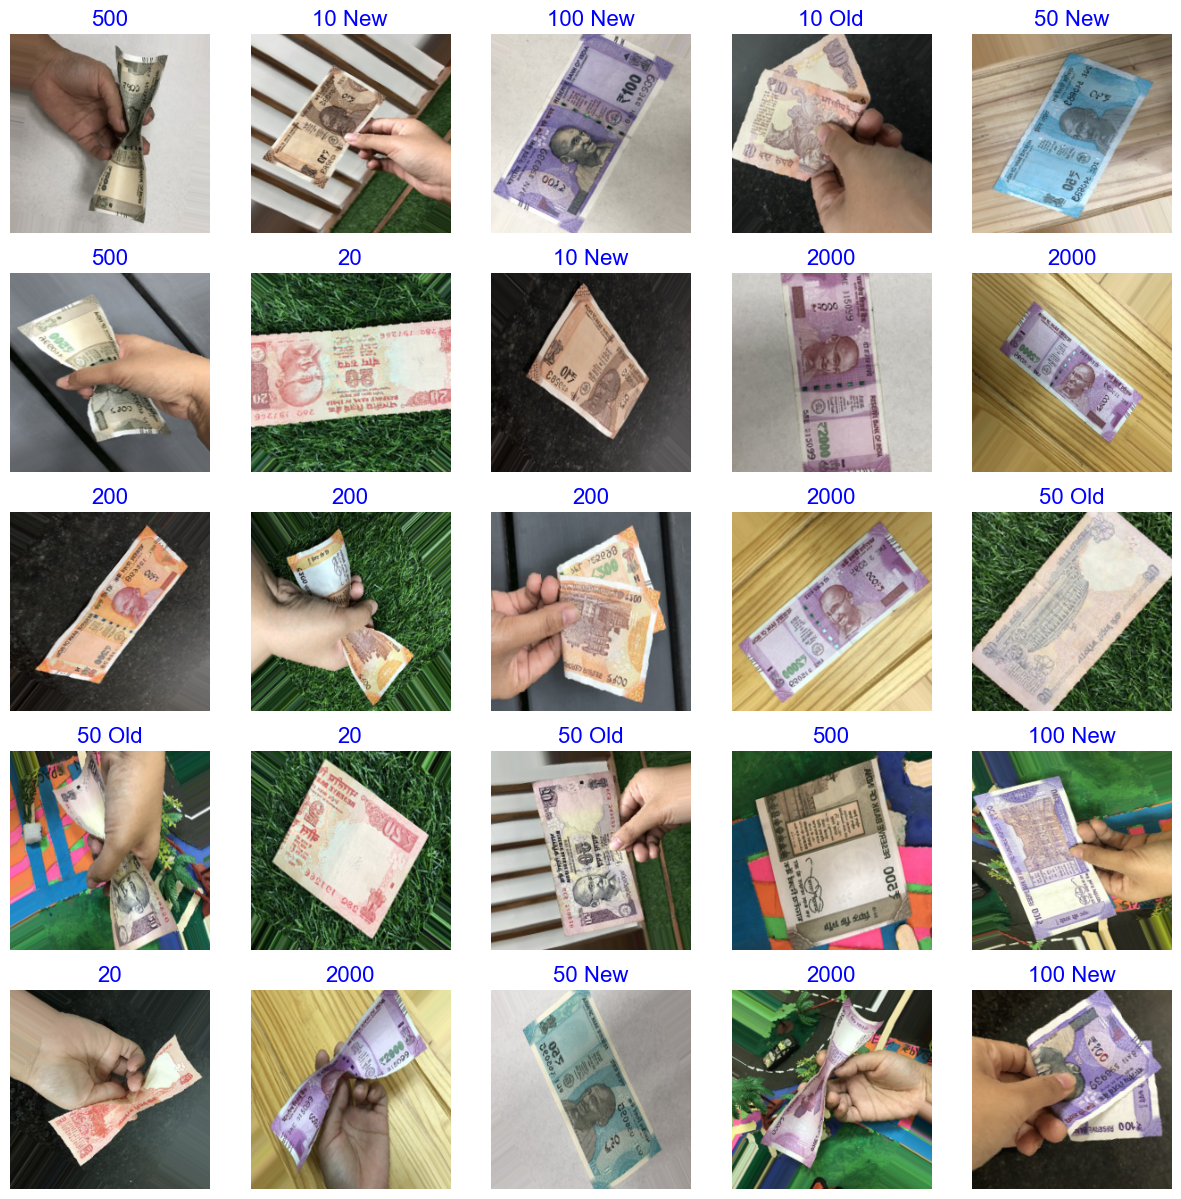

In [12]:
show_training_samples(train_gen)


# **create CNN¶**


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU, LeakyReLU, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply, Add, Reshape
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam
import random

image_shape = [224, 224, 3]

# Define the input layer
input_layer = Input(shape=image_shape)

# First Convolutional Block
x = Conv2D(16, kernel_size=(3, 3))(input_layer)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block
x = Conv2D(32, kernel_size=(3, 3))(x)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third Convolutional Block
x = Conv2D(64, kernel_size=(3, 3))(x)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)

# Channel Attention Module (CAM)
avg_pool = GlobalAveragePooling2D()(x)
max_pool = MaxPooling2D(pool_size=(x.shape[1], x.shape[2]))(x)  # Perform global max pooling
channel_attention = Add()([avg_pool, max_pool])
channel_attention = Dense(64, activation='relu')(channel_attention)
channel_attention = Dense(10, activation='Softmax')(channel_attention)  # Reduce to 1 channel
channel_attention = Multiply()([x, channel_attention])

# Spatial Attention Module (SAM)
avg_pool_spatial = GlobalAveragePooling2D()(x)
max_pool_spatial = MaxPooling2D(pool_size=(x.shape[1], x.shape[2]))(x)  # Perform global max pooling
spatial_attention = Add()([avg_pool_spatial, max_pool_spatial])
spatial_attention = Dense(64, activation='relu')(spatial_attention)
spatial_attention = Dense(10, activation='Softmax')(spatial_attention)  # Reduce to 1 channel
spatial_attention = Multiply()([x, spatial_attention])


# Attention Mechanism (2D)
attention = Conv2D(1, (3, 3), activation='Softmax', padding='SAME')(x)
attention = Reshape((52, 52, 1))(attention)  # Adjust the shape to match the feature map size
x = Multiply()([x, attention])

x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten
x = Flatten()(x)

# Rest of your model
x = Dense(256)(x)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)
x = Dropout(0.5)(x)

num_classes = 10  # Adjust this to your actual number of classes

# Output Layer for multi-class classification
output = Dense(num_classes, activation='softmax')(x)

# For a multi-class classification problem, use 'categorical_crossentropy' as the loss function
model.compile(loss='categorical_crossentropy', optimizer=optimizer_choice, metrics=['accuracy'])


optimizer_choice = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_choice, metrics=['accuracy'])

# Rest of your code (callbacks, training) remains the same
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=4, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

results = model.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks=[early_stop])

ValueError: Inputs have incompatible shapes. Received shapes (52, 52, 64) and (1, 1, 10)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU, LeakyReLU, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply, Add, Reshape, GlobalMaxPooling2D, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,AdamW
import random

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('softmax')(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    cbam_feature = input_feature

    avg_pool = tf.reduce_mean(cbam_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='softmax', kernel_initializer='he_normal', use_bias=False)(concat)
    
    return Multiply()([input_feature, cbam_feature])

image_shape = [224, 224, 3]
input_layer = Input(shape=image_shape)

# First Convolutional Block
x = Conv2D(16, kernel_size=(3, 3))(input_layer)
x = Activation(random.choice(['relu', 'leaky_relu']))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block
x = Conv2D(32, kernel_size=(3, 3))(x)
x = Activation(random.choice(['relu', 'leaky_relu']))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third Convolutional Block
x = Conv2D(64, kernel_size=(3, 3))(x)
x = Activation(random.choice(['relu', 'leaky_relu']))(x)
x = channel_attention(x)  # Apply Channel Attention after the block
x = spatial_attention(x)  # Apply Spatial Attention after channel attention

x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

num_classes = 10  # Number of classes
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

optimizer_choice = AdamW(learning_rate=0.003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_choice, metrics=['accuracy'])

# Rest of your code (callbacks, training) remains the same
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=4, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

results = model.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks=[early_stop])

Epoch 1/30
17/17 [==============================] - 32s 2s/step - loss: 2.1916 - accuracy: 0.1771 - val_loss: 1.9268 - val_accuracy: 0.2915
Epoch 2/30
17/17 [==============================] - 29s 2s/step - loss: 1.8595 - accuracy: 0.2952 - val_loss: 1.7103 - val_accuracy: 0.3424
Epoch 3/30
17/17 [==============================] - 29s 2s/step - loss: 1.7564 - accuracy: 0.3360 - val_loss: 1.6355 - val_accuracy: 0.4068
Epoch 4/30
17/17 [==============================] - 30s 2s/step - loss: 1.6370 - accuracy: 0.3805 - val_loss: 1.4454 - val_accuracy: 0.4542
Epoch 5/30
17/17 [==============================] - 30s 2s/step - loss: 1.4582 - accuracy: 0.4606 - val_loss: 1.3053 - val_accuracy: 0.4881
Epoch 6/30
17/17 [==============================] - 32s 2s/step - loss: 1.3280 - accuracy: 0.5117 - val_loss: 1.3137 - val_accuracy: 0.5322
Epoch 7/30
17/17 [==============================] - 35s 2s/step - loss: 1.2148 - accuracy: 0.5510 - val_loss: 0.9332 - val_accuracy: 0.6441
Epoch 8/30
17/17 [==

In [21]:
# Generate predictions on the validation set
y_pred = model.predict(valid_gen)

# Extract the true labels from the validation generator
y_true = valid_gen.classes  # Assuming you're using ImageDataGenerator

# Convert predicted probabilities to class indices for multiclass classification
y_pred = y_pred.argmax(axis=1)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

4/4 [==============================] - 1s 304ms/step
              precision    recall  f1-score   support

           0       0.60      0.55      0.58        38
           1       0.91      0.53      0.67        19
           2       0.96      0.96      0.96        24
           3       0.77      0.77      0.77        26
           4       0.96      0.61      0.75        36
           5       0.48      0.97      0.65        33
           6       0.93      0.93      0.93        27
           7       1.00      0.97      0.98        30
           8       0.96      0.69      0.80        32
           9       0.74      0.77      0.75        30

    accuracy                           0.77       295
   macro avg       0.83      0.77      0.78       295
weighted avg       0.82      0.77      0.77       295



In [22]:
# Save the entire model to an HDF5 file
model.save('full_99model.h5')

C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
best_optimizer_choice = optimizer_choice
best_activation_choice = activation_choice.__class__.__name__

print("Best Optimizer Choice:", best_optimizer_choice)
print("Best Activation Choice:", best_activation_choice)

Best Optimizer Choice: <keras.src.optimizers.adamw.AdamW object at 0x0000028229DB9B10>
Best Activation Choice: ReLU


In [24]:
import pandas as pd
loss_df = pd.DataFrame(model.history.history)
loss_df.columns

RangeIndex(start=0, stop=0, step=1)

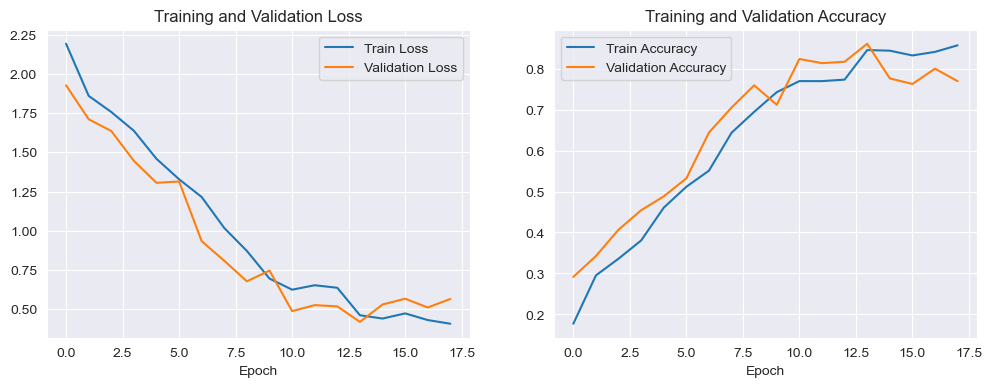

In [25]:

# Extract training and validation loss and accuracy
train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

# Show the plots
plt.show()

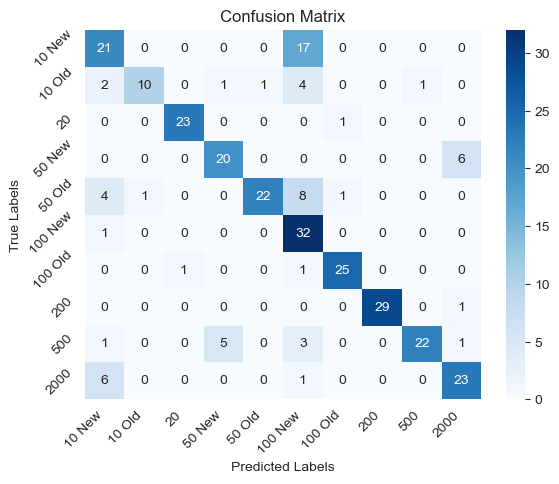

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class names based on the folder structure you provided
class_names = ['10 New', '10 Old', '20', '50 New', '50 Old', '100 New', '100 Old', '200', '500', '2000']

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Improve the layout to handle the increased number of classes
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

# Show the plot
plt.show()


In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported

1/1 [==============================] - 0s 22ms/step


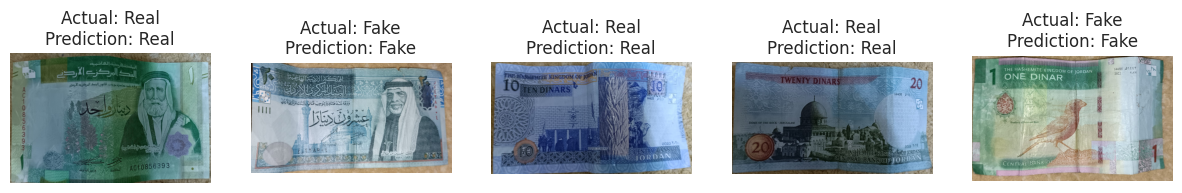

In [56]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/full_99model.h5')

# Define a function to preprocess an image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to your model's input size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Define a function to predict real or fake
def predict_real_or_fake(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    prediction = model.predict(image)
    return prediction

# List of image paths to predict
image_paths = ['/kaggle/input/prediction/1 R.jpg', '/kaggle/input/prediction/20 F.jpg', '/kaggle/input/prediction/10 R.jpg', '/kaggle/input/prediction/20 R.jpg', '/kaggle/input/prediction/1 F.jpg']
actual_labels = ["Actual: Real", "Actual: Fake", "Actual: Real", "Actual: Real", "Actual: Fake"]

# Create subplots to display images and actual labels side by side
fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))

for i, (image_path, actual_label) in enumerate(zip(image_paths, actual_labels)):
    prediction = predict_real_or_fake(image_path)
    
    if prediction >= 0.5:
        result = 'Real'
    else:
        result = 'Fake'
    
    # Display the image and actual label side by side
    image = cv2.imread(image_path)
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'{actual_label}\nPrediction: {result}')
    axs[i].axis('off')

plt.show()